In [37]:
import torch
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import perturbed_organics.utils as utils
import math


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cmap = 'plasma_r'

In [38]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)

folder_loc = f'/scratch/sr6364/perturbed_organics/data/adaptive_phase_diagram/{input_type}'
folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_100_num_input_100_num_trials_250_b0_1.0_b1_1.0_phase_diagram_log-scale'
# folder_name = f'{input_type}_goe_symmetric_N_100_s_100_mu_{mu}_num_delta_100_num_input_100_num_trials_250_b0_1.0_b1_1.0_phase_diagram_linear'
path = os.path.join(folder_loc, folder_name)

In [39]:
# Load parameters from the JSON file
param_file_path = os.path.join(path, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
input_scale = params['input_scale']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [40]:
condition = torch.load(os.path.join(path, f'condition.pt'))
norm_fixed_point_y = torch.load(os.path.join(path, f'norm_fixed_point_y.pt'))
actual_fixed_point_y = torch.load(os.path.join(path, f'actual_fixed_point_y.pt'))
first_order_perturb_y = torch.load(os.path.join(path, f'first_order_perturb_y.pt'))

In [41]:
bool_stable = torch.where(condition == 2, True, False)
# bool_limit_cycle = torch.where((condition == 0) | (condition == 3), True, False)
bool_limit_cycle = torch.where(condition == 3, True, False)
bool_not_converged = torch.where(condition == 0, True, False)
bool_unstable = torch.where(condition == 1, True, False)

In [42]:
# Proceed with plotting or further analysis
percent_stable = bool_stable.float().mean(dim=2) * 100
percent_notstable = 100 - percent_stable

percent_limit_cycle = bool_limit_cycle.float().mean(dim=2) * 100

percent_unstable = bool_unstable.float().mean(dim=2) * 100
percent_not_converged = bool_not_converged.float().mean(dim=2) * 100

In [43]:
# analytical prediction from perturbation theory
num_points_to_exclude = 3
idx = 0
norm_sol_idx = []
for input_norm in input_range:
    z = utils.make_input_drive(N=N, input_type=params['model_name'], input_norm=input_norm)
    norm_eqn = torch.sqrt(z ** 2 / (params['sigma']**2 + torch.norm(z) ** 2))
    norm_sol_idx.append(norm_eqn[idx].item())
norm_sol_idx = np.array(norm_sol_idx)

# analytical solution for the mean of the fixed point
G = (1 - np.sqrt(params['sigma'] ** 2 + input_range ** 2)) / (params['sigma'] ** 2 + input_range ** 2)
analytical_mean = norm_sol_idx + mu_val * input_range * G * (1 - input_range ** 2 / (params['sigma'] ** 2 + input_range ** 2)) / np.sqrt(N)


delta_c =  math.sqrt(2 * N) * analytical_mean / (G * input_range)
delta_c = delta_c[:-num_points_to_exclude]
new_input_norm = input_range[:-num_points_to_exclude]

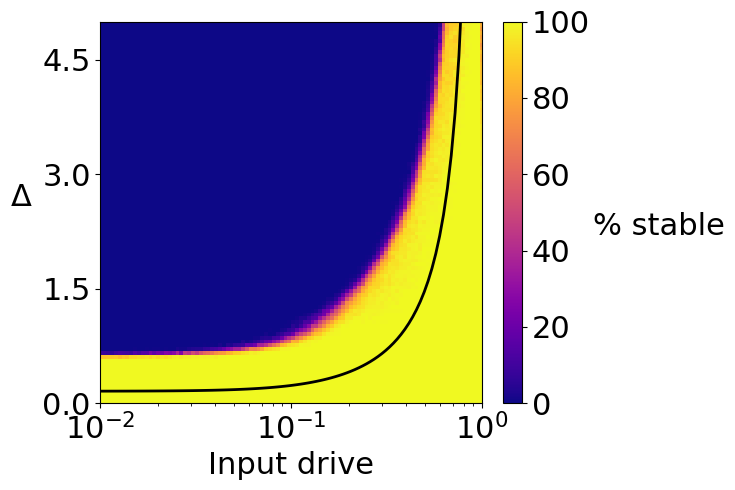

In [44]:
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_stable, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% stable", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


if input_scale == "log-scale":
    plt.xscale('log')  # Ensure the axis is in log scale
    ax = plt.gca()
    x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    ax = plt.gca()
    x_span = input_range[-1] - input_range[0]
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/percent_stable_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/percent_stable_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/percent_stable_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


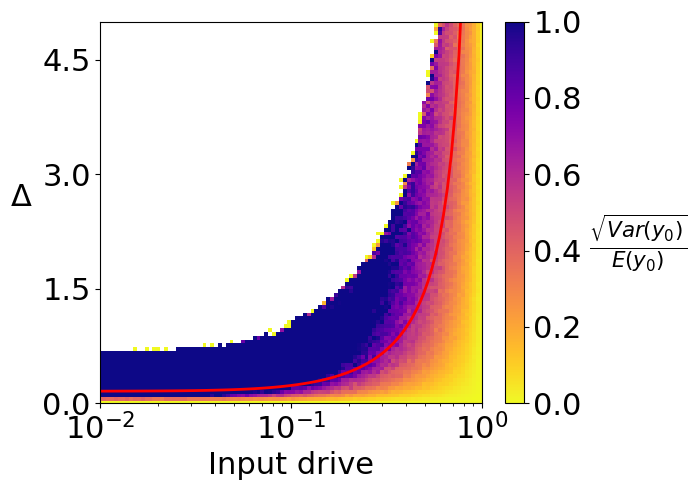

In [45]:
plt.figure(figsize=(7.5, 5))

idx = 0

norm = mcolors.Normalize(vmin=0, vmax=1, clip=True)

# calculate the avg ratio of deviation from norm fixed point for y
# y1_squared_norm = torch.norm(norm_fixed_point_y - actual_fixed_point_y, dim=3) ** 2 # deviation from the fixed point
# y0_squared_norm = torch.norm(norm_fixed_point_y, dim=3) ** 2
# y_ratio = y1_squared_norm / y0_squared_norm
# y_ratio_mean = torch.sqrt(torch.mean(y_ratio, dim=2))
# y_ratio_mean = torch.sqrt(torch.nanmean(y_ratio, dim=2))

# code for the standard deviation over mean criterion
y_val = actual_fixed_point_y[:, :, :, idx]
y_val_std = utils.nanstd(y_val, dim=2)
# y_val_std = np.nanstd(y_val, axis=2)
y_val_mean = torch.nanmean(y_val, dim=2)
y_ratio_mean = torch.abs(y_val_std / y_val_mean)

mesh = plt.pcolormesh(input_range, delta_range, y_ratio_mean, cmap=cmap, norm=norm)
plt.plot(new_input_norm, delta_c, color='red', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
# colorbar.ax.set_ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||}{||\mathbf{y}_0||}$", fontsize=22, rotation=0, labelpad=40)
colorbar.ax.set_ylabel(r"$\frac{\sqrt{Var(y_0)}}{E(y_0)}$", fontsize=22, rotation=0, labelpad=40)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
# plt.title("Actual Mean Ratio of Norm Difference for y", fontsize=22)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

if input_scale == "log-scale":
    plt.xscale('log')  # Ensure the axis is in log scale
    ax = plt.gca()
    x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    ax = plt.gca()
    x_span = input_range[-1] - input_range[0]
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/norm_ratio_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/norm_ratio_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/norm_ratio_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()

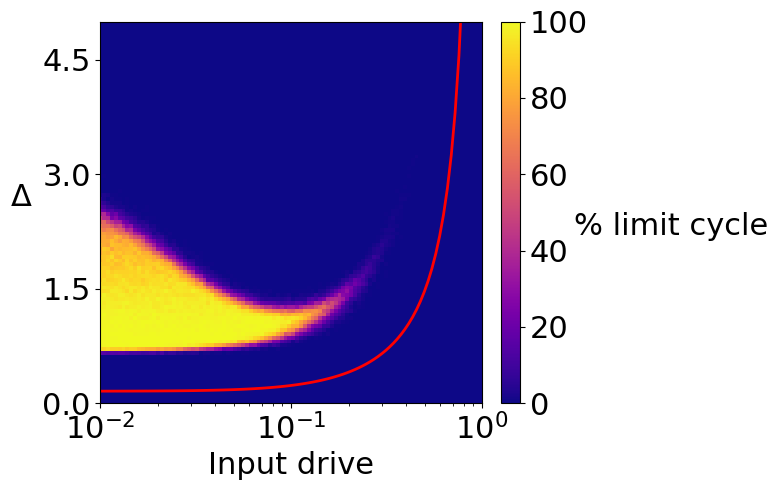

In [46]:
# We plot the percent of limit cycles detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_limit_cycle, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% limit cycle", fontsize=22, rotation=0, labelpad=60)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


if input_scale == "log-scale":
    plt.xscale('log')  # Ensure the axis is in log scale
    ax = plt.gca()
    x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    ax = plt.gca()
    x_span = input_range[-1] - input_range[0]
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/percent_limit_cycle_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/percent_limit_cycle_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/percent_limit_cycle_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


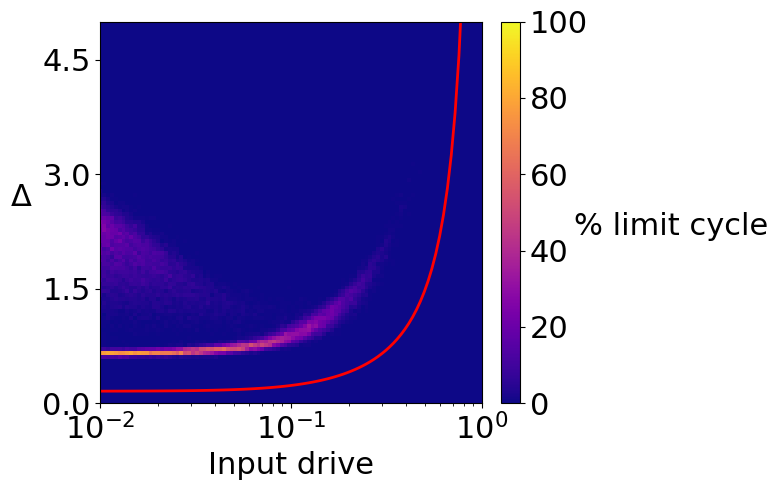

In [47]:
# We plot the percent of limit cycles detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_not_converged, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')

colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% limit cycle", fontsize=22, rotation=0, labelpad=60)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


if input_scale == "log-scale":
    plt.xscale('log')  # Ensure the axis is in log scale
    ax = plt.gca()
    x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    ax = plt.gca()
    x_span = input_range[-1] - input_range[0]
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/percent_not_converged_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/percent_not_converged_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/percent_not_converged_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


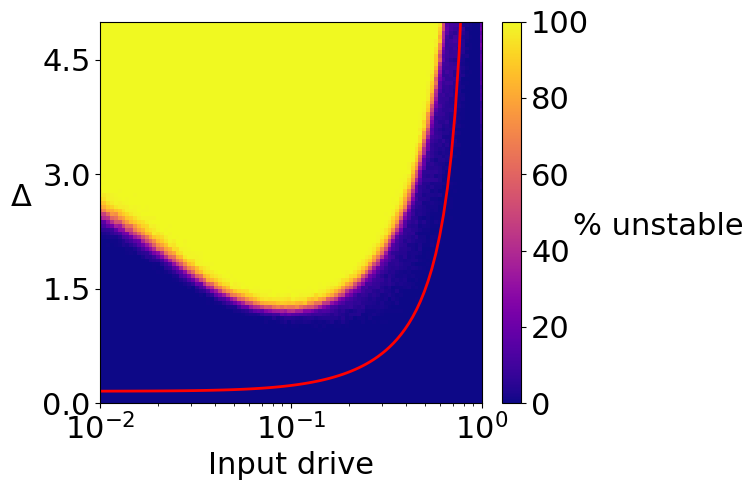

In [48]:
# We plot the percent of limit cycles detected

plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=0, vmax=100, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, percent_unstable, cmap='plasma', norm=norm)
plt.plot(new_input_norm, delta_c, color='r', linewidth=2.0, label=r'$\Delta_c$')


colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.ax.set_ylabel(r"% unstable", fontsize=22, rotation=0, labelpad=50)
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


if input_scale == "log-scale":
    plt.xscale('log')  # Ensure the axis is in log scale
    ax = plt.gca()
    x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    ax = plt.gca()
    x_span = input_range[-1] - input_range[0]
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.savefig(f'../figures/fig4/percent_unstable_{input_type}.png', bbox_inches='tight')
plt.savefig(f'../figures/fig4/percent_unstable_{input_type}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'../figures/fig4/percent_unstable_{input_type}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


### Dicover the pattern the about center manifold using the eigenvalues of the jacobian matrix

In [49]:
eigvals = torch.load(os.path.join(path, f'eigvals_J.pt'))
print(eigvals.shape) # num_delta, num_input, num_trials, 2*N)

torch.Size([100, 100, 250, 200])


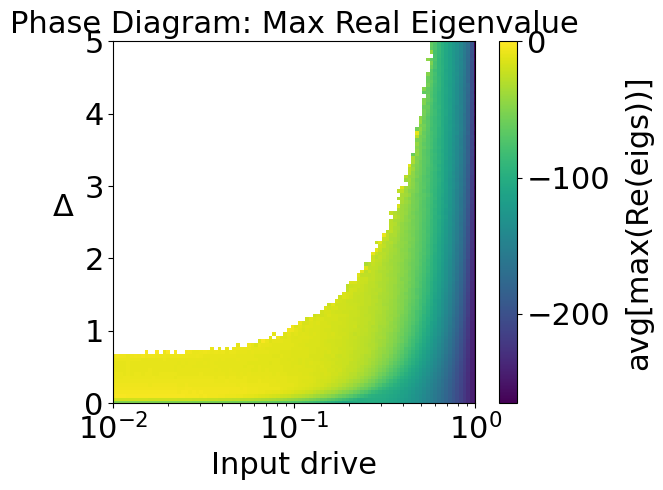

In [50]:
# Compute the maximum real part for each trial (max over eigenvalue index)
max_real_each_trial = torch.max(eigvals.real, dim=3)[0]  # shape: (num_delta, num_input, num_trials)

# Average over trials to get a 2D phase diagram (if desired)
max_real_avg = torch.nanmean(max_real_each_trial, dim=2)      # shape: (num_delta, num_input)

# Convert to NumPy for plotting
max_real_avg_np = max_real_avg.numpy()

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_real_avg_np)
vmax = np.nanmax(max_real_avg_np)

# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_avg_np, cmap='viridis', norm=norm)
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('avg[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Phase Diagram: Max Real Eigenvalue", fontsize=22)

if input_scale == "log-scale":
    plt.xscale('log')  # Ensure the axis is in log scale
    ax = plt.gca()
    x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    ax = plt.gca()
    x_span = input_range[-1] - input_range[0]
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.show()


/tmp/ipykernel_2480824/2898878398.py:5: RuntimeWarning: All-NaN slice encountered
  max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)


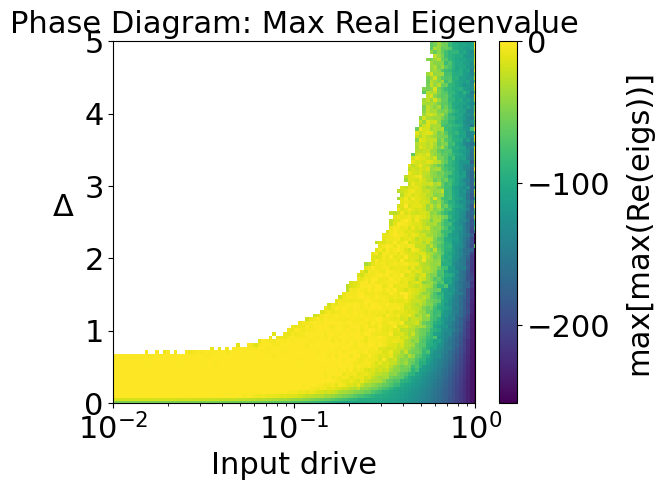

In [51]:
# Compute the maximum real part for each trial (max over eigenvalue index)
max_real_each_trial = torch.max(eigvals.real, dim=3)[0]  # shape: (num_delta, num_input, num_trials)

# find the max of the trials
max_real_max = np.nanmax(max_real_each_trial.numpy(), axis=2)

# Determine vmin and vmax ignoring NaN values
vmin = np.nanmin(max_real_max)
vmax = np.nanmax(max_real_max)

# Plot the phase diagram for max(real(eigenvalues)) using a sequential colormap ("viridis")
plt.figure(figsize=(7.5, 5))
norm = mcolors.Normalize(vmin=vmin, vmax=0.0, clip=False)
mesh = plt.pcolormesh(input_range, delta_range, max_real_max, cmap='viridis', norm=norm)
colorbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)
colorbar.ax.tick_params(labelsize=22)
colorbar.set_label('max[max(Re(eigs))]', fontsize=22, rotation=90, labelpad=10)

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Phase Diagram: Max Real Eigenvalue", fontsize=22)

if input_scale == "log-scale":
    plt.xscale('log')  # Ensure the axis is in log scale
    ax = plt.gca()
    x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    ax = plt.gca()
    x_span = input_range[-1] - input_range[0]
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])

plt.tight_layout()
plt.show()


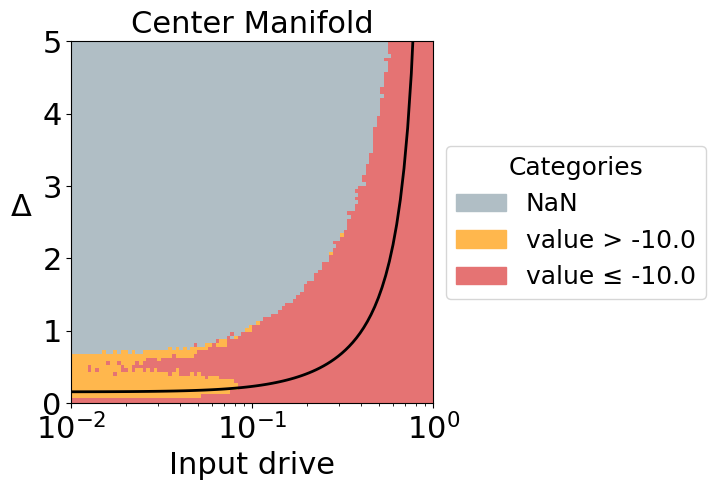

In [53]:
# Define hex codes for the three colors (change these as needed)
color_nan = "#B0BEC5"    # For NaN values
color_class1 = "#FFB74D" # For values > threshold (and < 0)
color_class2 = "#E57373" # For values ≤ threshold

# Define the threshold for center manifold (adjust as needed)
threshold = -10.0

qty_to_check = max_real_avg_np
# qty_to_check = max_real_max

# Create a classification array with the same shape as qty_to_check
# We assign:
#   0 for NaN values,
#   1 for values in (threshold, 0),
#   2 for values less than or equal to threshold.

classification = np.zeros_like(qty_to_check, dtype=int)
# Mark NaN values
nan_mask = np.isnan(qty_to_check)
classification[nan_mask] = 0  
# For non-NaN values, assign classes:
non_nan = ~nan_mask
# Class 1: threshold < value < 0
mask1 = (qty_to_check > threshold) & non_nan
classification[mask1] = 1
# Class 2: value ≤ threshold
mask2 = (qty_to_check <= threshold) & non_nan
classification[mask2] = 2

# Create a discrete colormap using the defined colors
from matplotlib.colors import ListedColormap
colors = [color_nan, color_class1, color_class2]
discrete_cmap = ListedColormap(colors)

# Plot the new classification
plt.figure(figsize=(7.5, 5))
mesh = plt.pcolormesh(input_range, delta_range, classification, cmap=discrete_cmap, shading='auto')
plt.plot(new_input_norm, delta_c, color='k', linewidth=2.0, label=r'$\Delta_c$')
plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r'$\Delta$', fontsize=22, rotation=0, labelpad=15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Center Manifold", fontsize=22)

# Create a custom legend with the legend positioned outside the figure
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=color_nan, label='NaN'),
    mpatches.Patch(color=color_class1, label=f'value > {threshold}'),
    mpatches.Patch(color=color_class2, label=f'value ≤ {threshold}')
]
plt.legend(handles=legend_handles, fontsize=18, title="Categories", title_fontsize=18,
           loc='center left', bbox_to_anchor=(1, 0.5))

if input_scale == "log-scale":
    plt.xscale('log')  # Ensure the axis is in log scale
    ax = plt.gca()
    x_span = np.log10(input_range[-1]) - np.log10(input_range[0])
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')
else:
    ax = plt.gca()
    x_span = input_range[-1] - input_range[0]
    y_span = delta_range[-1] - delta_range[0]
    ax.set_aspect(x_span / y_span, adjustable='box')

plt.xlim([input_range[0], input_range[-1]])
plt.ylim([delta_range[0], delta_range[-1]])
plt.tight_layout()

plt.show()


delta: 0.25252525252525254, input: 0.01


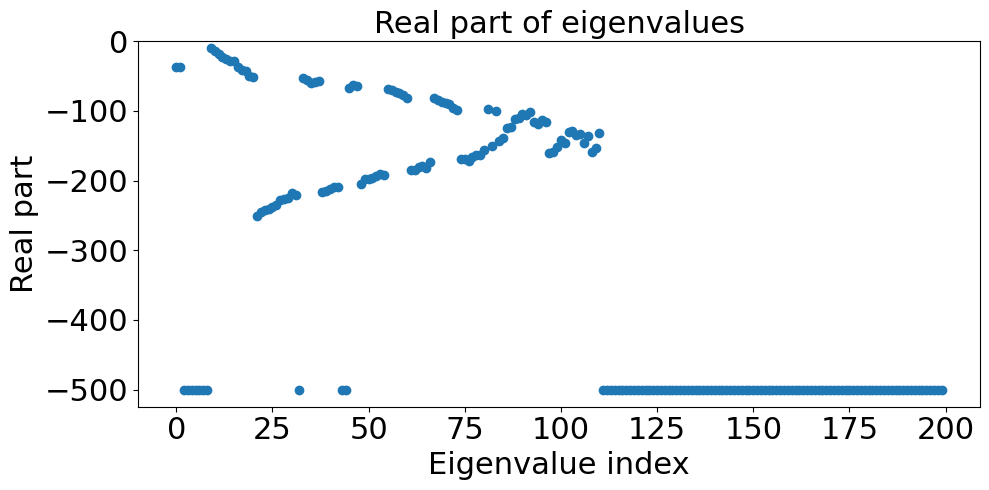

In [64]:
# finding the separation of scales in the center manifold and stable regions
trial_idx = 0
delta_idx = 5
input_idx = 0
sample_eigval = eigvals[delta_idx, input_idx, trial_idx, :]
sample_eigval_real = sample_eigval.real

print(f'delta: {delta_range[delta_idx]}, input: {input_range[input_idx]}')

# plot the real part of eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(sample_eigval_real, 'o')
plt.xlabel('Eigenvalue index', fontsize=22)
plt.ylabel('Real part', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Real part of eigenvalues', fontsize=22)
# Let matplotlib autoscale the y-axis first
plt.autoscale(axis='y')

# Get the current lower limit
current_bottom, _ = plt.ylim()

# Set only the upper limit to 0, while retaining the autoscaled lower limit
plt.ylim(current_bottom, 0)

plt.tight_layout()
plt.show()

delta: 0.5050505050505051, input: 0.6579332246575682


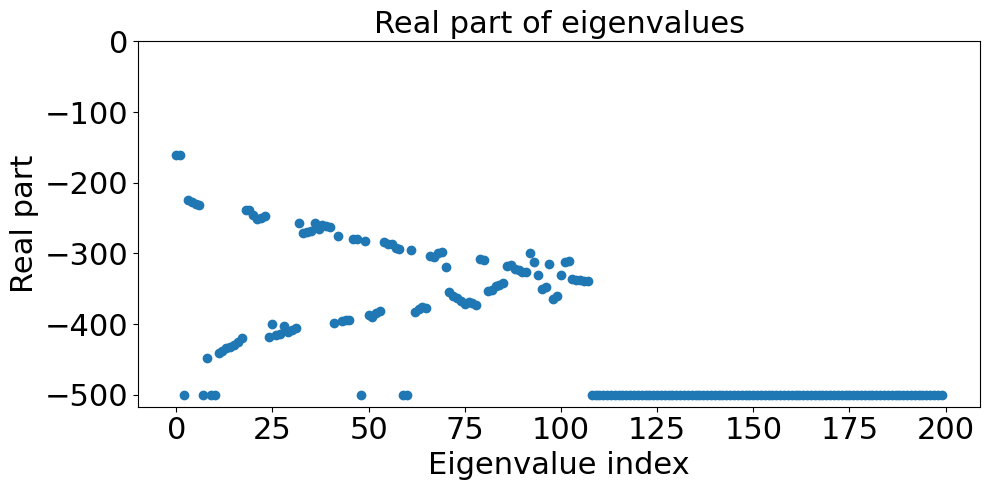

In [79]:
# finding the separation of scales in the center manifold and stable regions
delta_idx = 10
input_idx = 90
trial_idx = 0
sample_eigval = eigvals[delta_idx, input_idx, trial_idx, :]
sample_eigval_real = sample_eigval.real

print(f'delta: {delta_range[delta_idx]}, input: {input_range[input_idx]}')

# plot the real part of eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(sample_eigval_real, 'o')
plt.xlabel('Eigenvalue index', fontsize=22)
plt.ylabel('Real part', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Real part of eigenvalues', fontsize=22)
plt.tight_layout()

# Let matplotlib autoscale the y-axis first
plt.autoscale(axis='y')

# Get the current lower limit
current_bottom, _ = plt.ylim()

# Set only the upper limit to 0, while retaining the autoscaled lower limit
plt.ylim(current_bottom, 0)
plt.show()